Import Library Yang Digunakan

In [98]:
import zipfile
import os
import glob 
import warnings

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [100]:
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Masuk Dalam Ke Direktori Dataset

In [101]:
cd /content/drive/MyDrive/Colab Notebooks/CC

/content/drive/MyDrive/Colab Notebooks/CC


In [102]:
ls

dataset/  dataset_wajah.zip  logs/


Melakukan Ekstrak File Dataset

In [103]:
ekstrak_zip = 'dataset_wajah.zip'
out_zip = zipfile.ZipFile(ekstrak_zip, 'r')
out_zip.extractall('/dataset_wajah')
out_zip.close()

Mengatur Lokasi Direktori Dataset

In [104]:
dir_dataset = "/dataset_wajah/wajah"
dir_wajahberkomedo = os.path.join("/dataset_wajah/wajah/wajahberkomedo")
dir_wajahnormal = os.path.join("/dataset_wajah/wajah/wajahnormal")

In [105]:
total_image = len(list(glob.iglob("/dataset_wajah/wajah/*/*.*", recursive=True)))
total_wajahberkomedo = len(os.listdir(dir_wajahberkomedo))
total_wajahnormal = len(os.listdir(dir_wajahnormal))

Menghitung Jumlah File Dataset

In [106]:
print("Total Data Wajab Berkomedo      : ",total_wajahberkomedo)
print("Total Data Wajah Normal       : ",total_wajahnormal)
print("Total Data Image JPEG     : ",total_image)

Total Data Wajab Berkomedo      :  162
Total Data Wajah Normal       :  600
Total Data Image JPEG     :  762


Pengaturan Image Data Generator Tensorflow Untuk Pengolahan Gambar

In [107]:
val_size = 0.2
Train_datagen = ImageDataGenerator(
    rotation_range = 45,
    brightness_range = [0.2,1.0],
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)
Validation_datagen = ImageDataGenerator(
    rotation_range = 45,
    brightness_range = [0.2,1.0],
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Mengatur Dimensi Gambar

In [108]:
img_width = 200
img_height = 200

Melakukan Split Dataset Train dan Validation Dengan Ukuran Validasi 20%

In [109]:
Train_generator = Train_datagen.flow_from_directory(
    dir_dataset,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 20,
    shuffle = True,
    subset = "training"
)
Validation_generator = Validation_datagen.flow_from_directory(
    dir_dataset,
    target_size = (img_width,img_height),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 20,
    shuffle = False,
    subset = "validation"
)

Found 610 images belonging to 2 classes.
Found 152 images belonging to 2 classes.


Mengatur Model Sequential Yang Digunakan

In [110]:
Model = Sequential(
    [Conv2D(16, (3,3), strides = (1,1), activation = 'relu' , input_shape = (img_width,img_height,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),
     Dropout(0.3),
     Dense(128, activation = 'relu'),
     Dense(2, activation='softmax')
    ]
)

In [111]:
Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 23, 23, 64)      

Mengatur Optimizer Yang Digunakan

In [112]:
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

Mengatur Learning Rate Schedule dan Callbacks Yang Digunakan

In [113]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

Melakukan Training Pada Dataset

In [115]:
batch_size = 20
with tf.device("/device:GPU:0"):
  history = Model.fit(Train_generator, 
                    epochs =  30, 
                    steps_per_epoch = 610//batch_size, 
                    validation_data = Validation_generator, 
                    verbose = 1, 
                    validation_steps = 152//batch_size,
                    callbacks =[lr_schedule, tb_callback])


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
30/30 [==============================] - 34s 1s/step - loss: 0.1478 - accuracy: 0.9475 - val_loss: 0.3277 - val_accuracy: 0.8571 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
30/30 [==============================] - 34s 1s/step - loss: 0.2097 - accuracy: 0.9317 - val_loss: 0.1707 - val_accuracy: 0.9357 - lr: 0.0010

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
30/30 [==============================] - 34s 1s/step - loss: 0.1067 - accuracy: 0.9576 - val_loss: 0.0796 - val_accuracy: 0.9714 - lr: 0.0010

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
30/30 [==============================] - 34s 1s/step - loss: 0.0726 - accuracy: 0.9746 - val_loss: 0.1447 - val_accuracy: 0.9357 - lr: 0.0010

Epoch 00005: LearningRateScheduler setting learning

Membuat Plot Accuracy dan Loss Pada Hasil Training Dataset

In [116]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

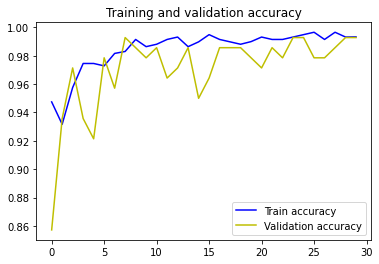

<Figure size 432x288 with 0 Axes>

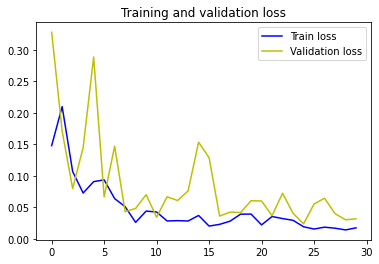

<Figure size 432x288 with 0 Axes>

In [117]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Train accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Melakukan Upload File Gambar Untuk Dilakukan Prediksi

Saving 16.jpg to 16.jpg


	 Wajah Berkomedo


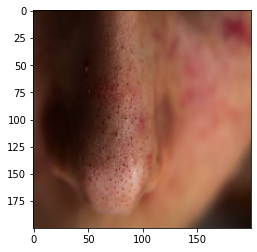

In [131]:
uploaded = files.upload()

for file_upload in uploaded.keys():
  path = file_upload
  img = image.load_img(path, target_size=(200,200))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = Model.predict(images, batch_size=20)
  
  print("\n")
  if classes[0][0] == 1:
    print('\t Wajah Berkomedo')
  elif classes[0][1] == 1:
    print('\t Wajah Normal')